<a href="https://colab.research.google.com/github/pacayton/GARCH_MIDAS_PARK-R/blob/main/GARCH_MiDaS_PARK_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GARCH-MiDaS-PARK-R Demonstration

by Assoc Prof Peter Julian A Cayton, PhD



Preamble Code for packages to be used:

In [4]:
install.packages(c("rumidas", "rugarch", "tidyverse", "forecast", "GGally"))
library("rumidas")
## for the MiDaS methodology
library("rugarch")
## for the GARCH approach
library("tidyverse")
## for data management
library("forecast")
## for forecasting tools
library("xts")
## for management of daily data

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Data to be used:

1. (psei) The Philippine Stock Exchange Index dataset, from January 2, 2004 to March 5, 2021.

2. (ind) The MISSI data, which contains the Volume of Producting Index (VoPI) Year-on-Year growth rate and Volume of Net Sales index (VoNSI) Year-on-Year growth rate, from January 2007 to February 2021

In [11]:
psei <- read.csv("https://raw.githubusercontent.com/pacayton/GARCH_MIDAS_PARK-R/refs/heads/main/PSEI.PS.csv", na.strings="null")
ind <- read.csv("https://raw.githubusercontent.com/pacayton/GARCH_MIDAS_PARK-R/refs/heads/main/VOPI_VONS.csv")

Data cleaning and processing:


1. Solving for the Parkinson Range

In [12]:
psei$park_r <- (log(psei$High) - log(psei$Low))/sqrt(4*log(2))*100

2. Convert date variables to appropriate format and restricting range to between 2007 and 2019

In [29]:
psei <- na.omit(psei)
psei$Date <- as.Date(psei$Date)
psei <- psei[which(year(psei$Date) >= 2007 & year(psei$Date) < 2020),]

ind$Date <- as.Date(ind$Date)
ind <- ind[which(year(ind$Date) < 2020),]

3. Combining datasets for analysis

In [30]:
## Daily Data
return <- diff(log(psei$Adj.Close))*100
return <- c(NA, return)
vopi <- as.numeric(rep(NA, times=length(return)))
vonsi <- as.numeric(rep(NA, times=length(return)))
diff_inf <- as.numeric(rep(NA, times=length(return)))
rv <- as.numeric(rep(NA, times=length(return)))
ind_date <- as.Date(rep(NA, times=length(return)), format="%Y-%m-%d")
Mth_Year <- format(psei$Date,"%Y-%m")

psei_dat <- data.frame(Date= psei$Date, Adj.Close = psei$Adj.Close,
park_r = psei$park_r, return=return, vopi, vonsi, rv, Mth_Year =Mth_Year,
ind_date=ind_date)

In [42]:
## Monthly Data
rv <- tapply(psei_dat$return, Mth_Year,var, na.rm=TRUE)

Mth_Year_ind <- format(ind$Date,"%Y-%m")

ind_dat <- data.frame(date= ind$Date, vopi=ind$VoPI_YOY_Growth, vonsi=ind$VoNSI_YOY_Growth, rv = rv, Mth_Year =Mth_Year_ind)

In [44]:
## Merging Monthly and Daily Data
len_ind <- dim(ind_dat)[1]
len_psei <- dim(psei_dat)[1]

for (i in 1:len_ind) {
  for (j in 1:len_psei) {
    if (ind_dat$Mth_Year[i] == psei_dat$Mth_Year[j]) {
      psei_dat$vopi[j] <- ind_dat$vopi[i]
      psei_dat$vonsi[j] <- ind_dat$vonsi[i]
      psei_dat$ind_date[j] <- ind_dat$date[i]
      psei_dat$rv[j] <- ind_dat$rv[i]
    }
  }
}

## Clean Out rows with NAs

psei_dat <- na.omit(psei_dat)

Historical Plots

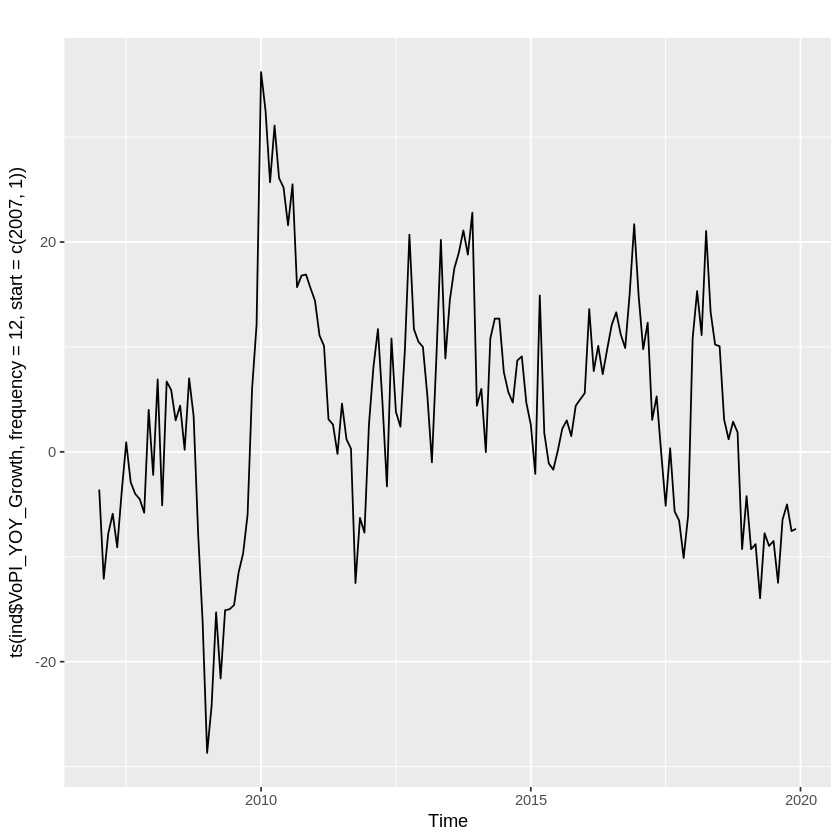

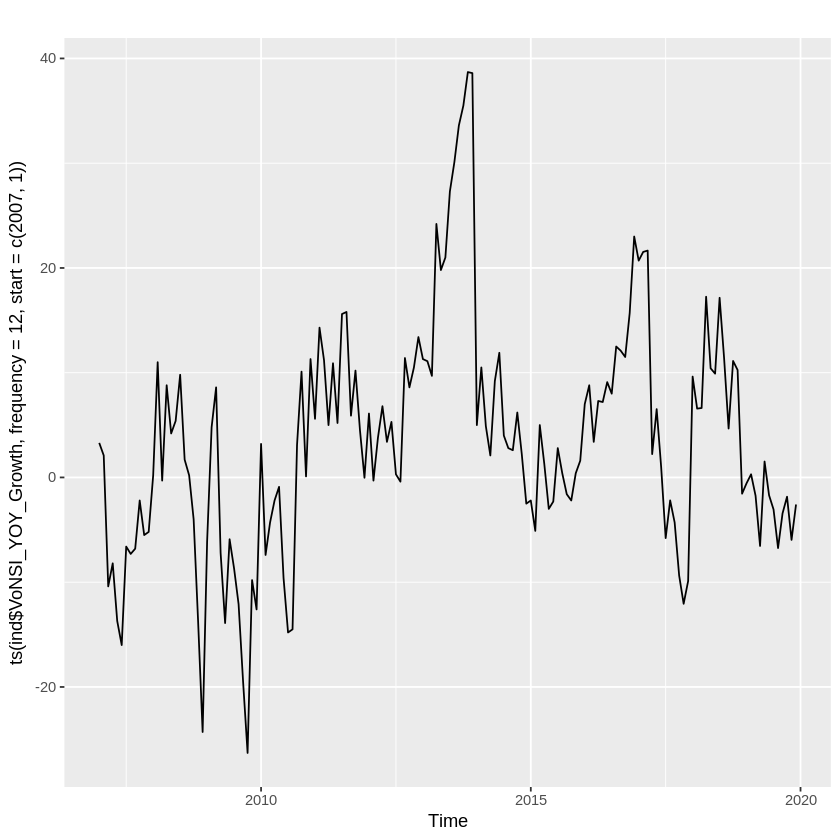

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


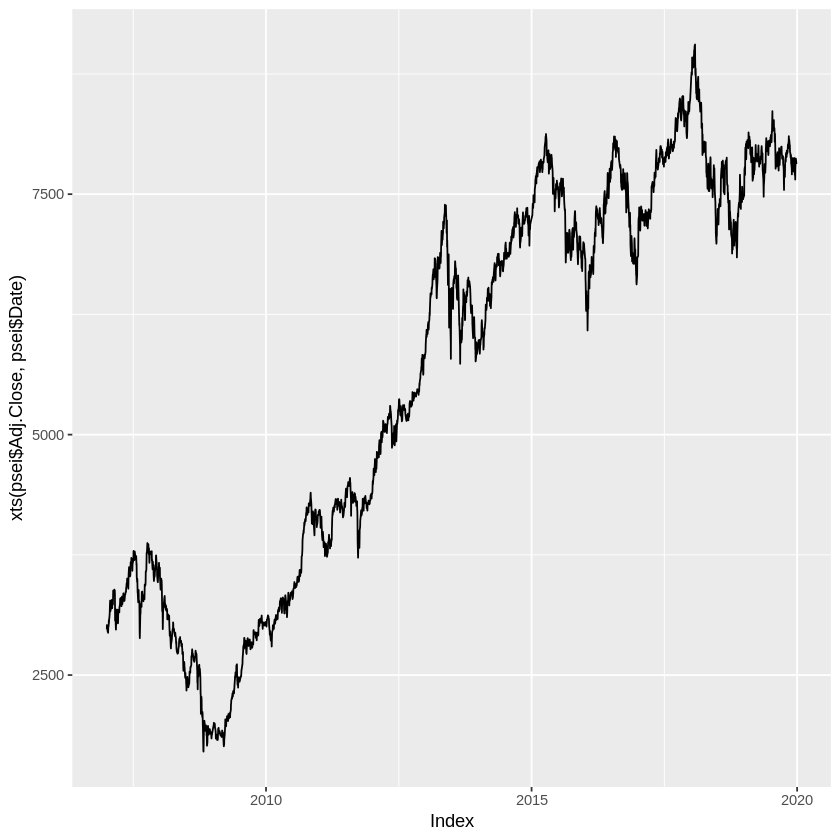

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


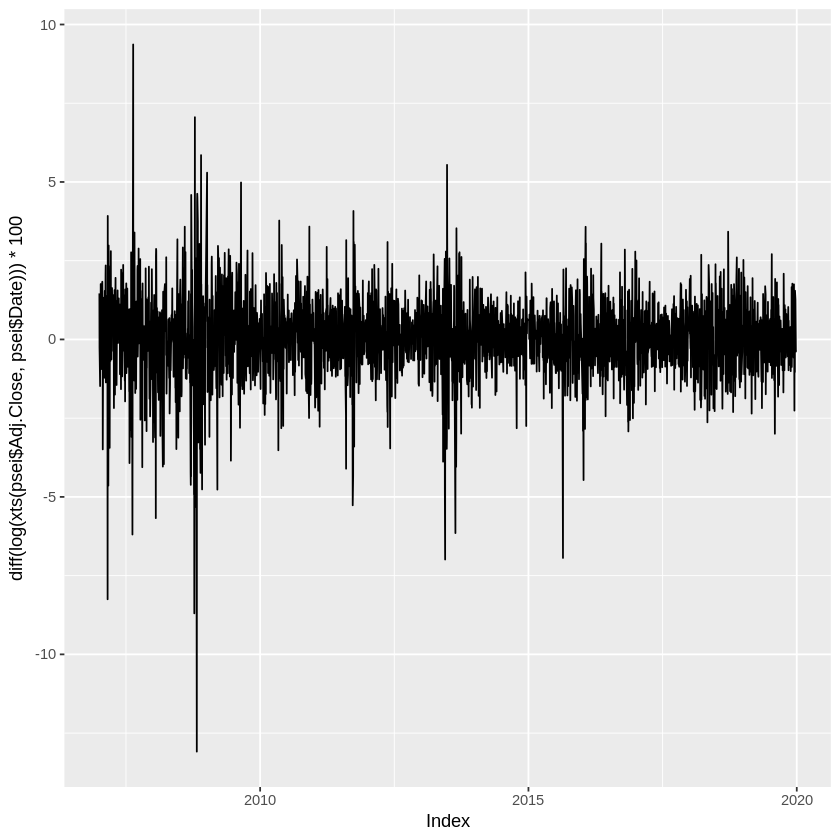

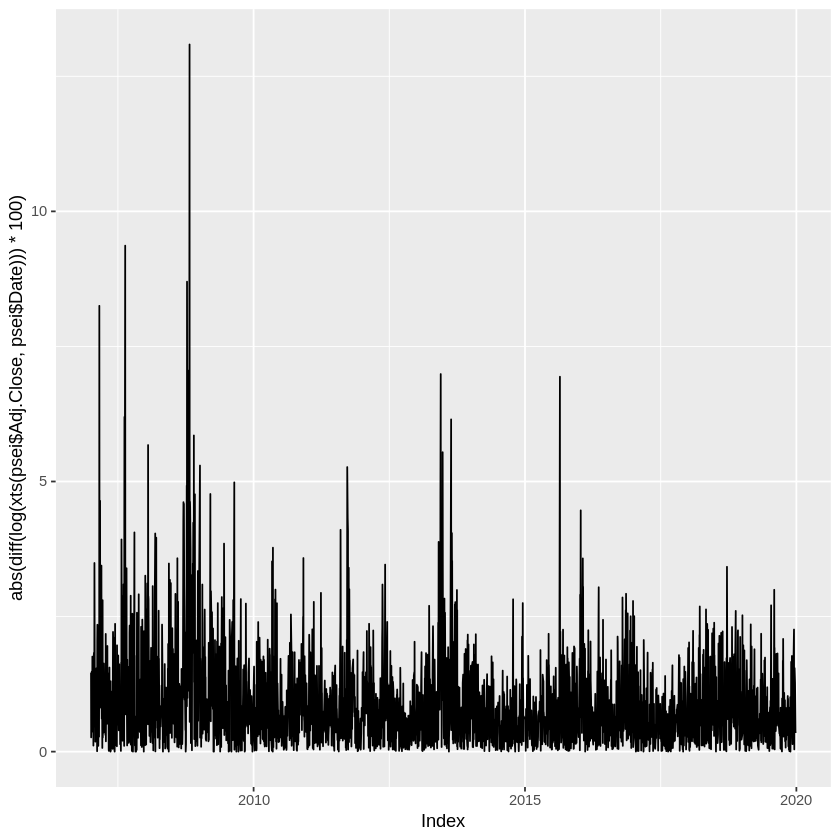

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



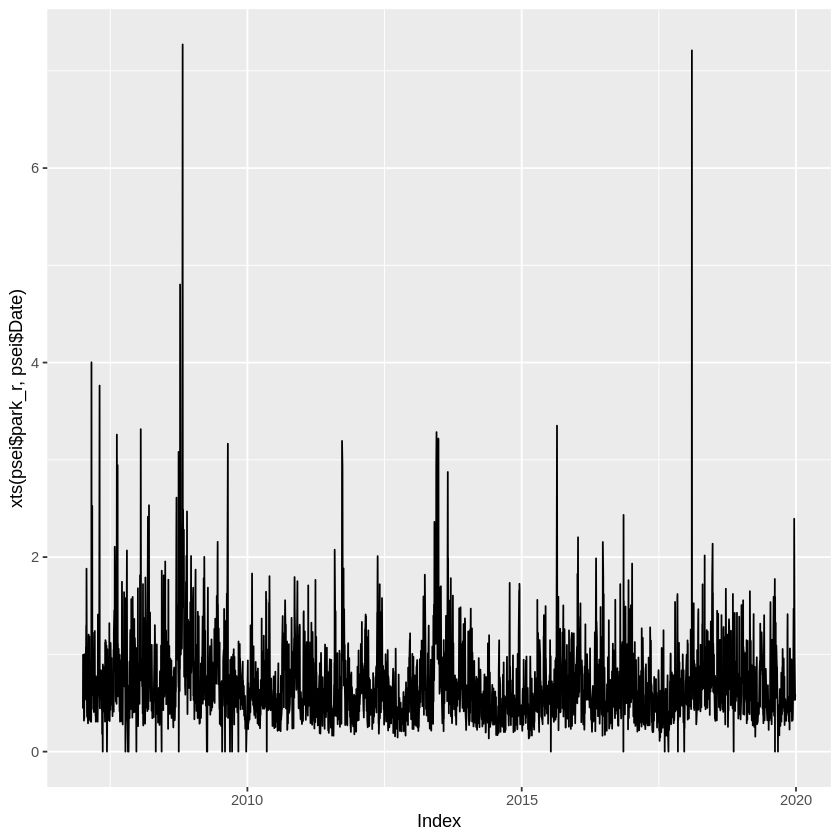

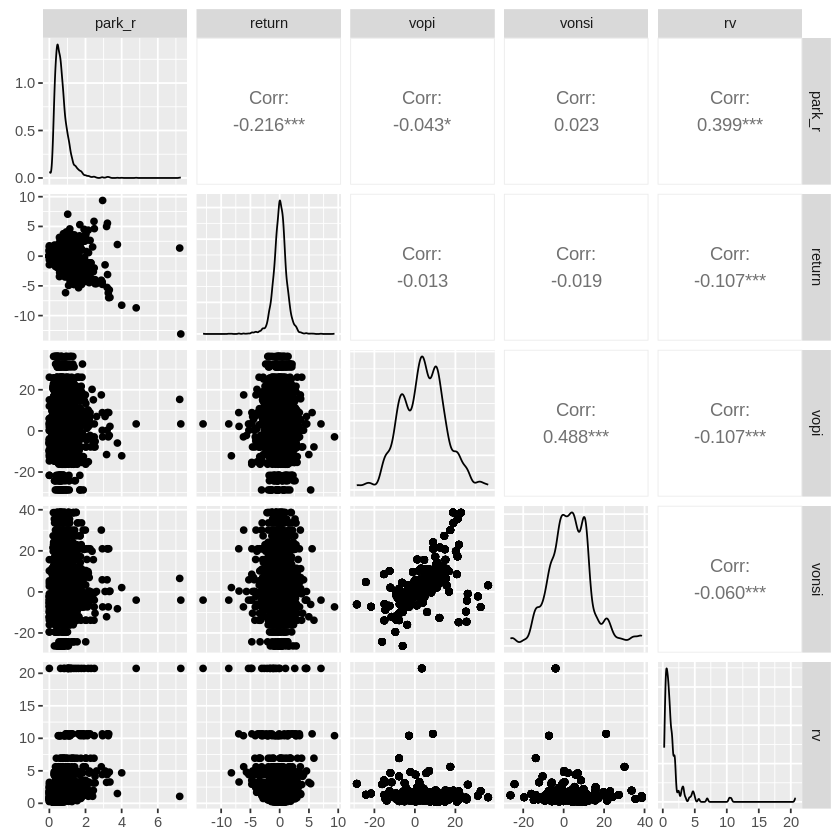

In [52]:
## Initial Plots of the Data
autoplot(ts(ind$VoPI_YOY_Growth, frequency = 12, start = c(2007, 1)))
autoplot(ts(ind$VoNSI_YOY_Growth, frequency = 12, start = c(2007, 1)))
autoplot(xts(psei$Adj.Close, psei$Date))
autoplot(diff(log(xts(psei$Adj.Close, psei$Date)))*100)
autoplot(abs(diff(log(xts(psei$Adj.Close, psei$Date)))*100))
autoplot(xts(psei$park_r,psei$Date))

GGally::ggpairs(psei_dat[,3:7])

Modeling with the GARCH-MiDaS-PARK-R

GARCH(1,1)-MiDaS-PARK-R Model

\begin{align}
R_{Park, l,t} & = \mu_{l,t} \epsilon_{l,t}, \\
\mu_{l,t} & =\tau_t h_{l,t}, \\
\epsilon_{l,t} | I_{l-1,t} & \sim iid (1,\phi_{l,t}) \\
\log \left( \tau_t  \right) & = m + \theta \sum^{K}_{k=1} \phi_k \left( \omega_2 \right) X_{t-k} \\
 h_{l,t} & = (1-\alpha_1-\beta_1 ) +\alpha_1 \frac{R_{Park, l-1,t}}{\tau_t} + \beta_1 \frac{\mu_{l-1,t}}{\tau_t}\\
\phi_k \left(\omega_2 \right) & = \frac{\left(1- k/K \right)^{\omega_2 -1}}{\sum^{K}_{s=1} \left(1-s/K \right)^{\omega_2 -1}}
\end{align}

GARCH(1,1)-MiDaS-PARK-R in QMLE specification

\begin{align}
\sqrt{R_{Park, l,t}} & = \sqrt{\mu_{l,t}} \nu_{l,t}, \\
 \mu_{l,t} & =\tau_t h_{l,t}, \\
 \nu_{l,t} | I_{l-1,t} & \sim iid (0,1) \\
 \log \left( \tau_t  \right) & = m + \theta \sum^{K}_{k=1} \phi_k \left( \omega_2 \right) X_{t-k} \\
 h_{l,t} & = (1-\alpha_1-\beta_1 ) +\alpha_1 \frac{R_{Park, l-1,t}}{\tau_t} + \beta_1 \frac{\mu_{l-1,t}}{\tau_t}\\
\phi_k \left(\omega_2 \right) & = \frac{\left(1- k/K \right)^{\omega_2 -1}}{\sum^{K}_{s=1} \left(1-s/K \right)^{\omega_2 -1}}
\end{align}

1. Train-test Splitting

In [64]:
test <- 250
## Length of the test dataset

### Rt for Modeling
r_t <- xts(psei_dat$return[which(year(psei_dat$Date) > 2008)], psei_dat$Date[which(year(psei_dat$Date) > 2008)])

## For VoPI
vopi <- xts(ind_dat$vopi, ind_dat$date)
mv_m_v<-mv_into_mat(r_t,vopi,K=12,"monthly")

## Volatility Proxy: Squared Parkinson Range
park_sq <- (xts(psei_dat$park_r[which(year(psei_dat$Date) > 2008)], psei_dat$Date[which(year(psei_dat$Date) > 2008)]))^2

## For Realized Volatility (Daily, Aggregated by Month)
rv <- xts(ind_dat$rv, ind_dat$date)
mv_m_r <- mv_into_mat(r_t,rv,K=12,"monthly")

### Park R
pr_t <- xts(psei_dat$park_r[which(year(psei_dat$Date) > 2008)], psei_dat$Date[which(year(psei_dat$Date) > 2008)])

### Sqrt Park R
sq_pr_t <- sqrt(pr_t)

## Split the data
pr_t_train <- pr_t[1:(length(pr_t)-test)]
pr_t_test <- pr_t[(length(pr_t)-test+1):length(pr_t)]



2. Model Estimation, VOPI as the macroeconomic variable

In [69]:
pgmv_fit<-ugmfit(
  model="GM", ## GARCH-MiDaS specification
  skew="NO", ## Symmetric (not GJRGARCH) specification
  distribution="norm", ## Normal Distribution for QMLE approach
  sq_pr_t , ## Sqrt Parkinson Range as the Y value
  mv_m_v, ## Matrix form of the VOPI
  K=12, ## Monthly Data
  out_of_sample = test, ## Specification of Test data length
  vol_proxy = pr_t) ## Volatility Proxy as Std Dev: Parkinson Range

summary.rumidas(pgmv_fit)




Coefficients:
      Estimate Std. Error  t value Pr(>|t|) Sig.
alpha   0.0240     0.0076   3.1488   0.0016  ***
beta    0.3826     0.2134   1.7925   0.0731    *
m      -3.6679     0.1630 -22.4981   0.0000  ***
theta  -0.0169     0.0087  -1.9486   0.0513    *
w2      4.2707     1.7209   2.4817   0.0131   **
--- 
Signif. codes: 0.01 '***', 0.05 '**', 0.1 '*' 

Obs.: 2431. Sample Period: 2009-01-05/2018-12-17 
MSE(%): 54.738828;  QLIKE: 10.92902 



3. Plot of the predicted Parkinson Range based on the GARCH-MiDaS-Park-R

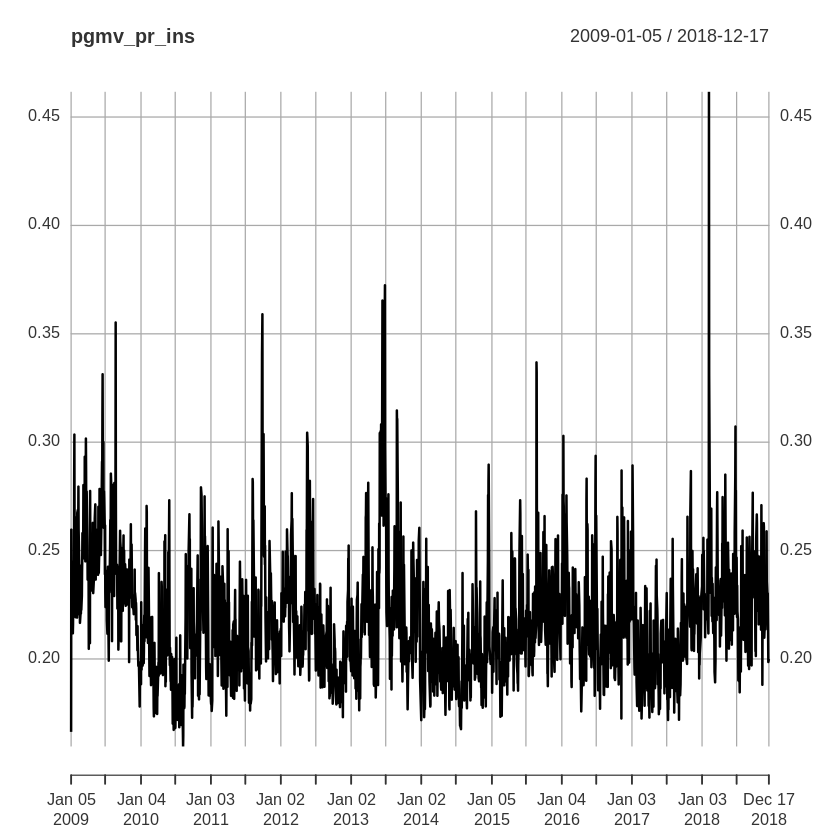

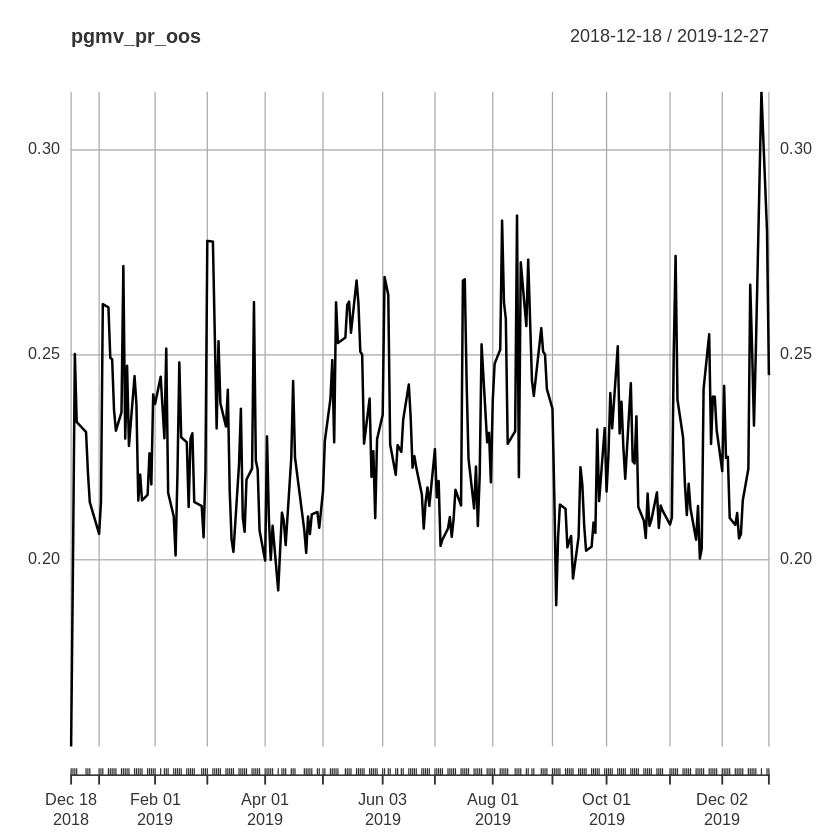

In [73]:
pgmv_pr_ins <- pgmv_fit$est_vol_in_s
pgmv_pr_oos <- pgmv_fit$est_vol_oos

plot(pgmv_pr_ins)
plot(pgmv_pr_oos)